In [134]:
from matplotlib import pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

import warnings
import numpy as np
import pandas as pd
import yfinance as yf

In [135]:
plt.rc('font', family='GULIM')
warnings.filterwarnings(action='ignore')
InteractiveShell.ast_node_interactivity = "all"

# Oil Price

In [139]:
import requests

api_key = '2LMFTJQ7V0USVG0B'

params = {
    'function': 'WTI',
    'interval': 'weekly',
    'apikey': api_key
}

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=WTI&interval=monthly&apikey=demo'
r = requests.get(url, params=params)
data = r.json()

In [137]:
SP = pd.DataFrame(columns=['date', 'price'])
for i in range(len(data['data'])):
    SP.loc[i, 'date'] = data['data'][i]['date']
    SP.loc[i, 'price'] = data['data'][i]['value']
SP.index = SP['date']
SP.drop(columns='date', inplace=True)
SP.sort_index(inplace=True)
SP['price'] = pd.to_numeric(SP['price'], errors='coerce')

KeyError: 'data'

In [141]:
CL = yf.download('CL=F', start='2000-08-23')
HO = yf.download('HO=F', start='2000-09-01')
RB = yf.download('RB=F', start='2000-11-01')
BZ = yf.download('BZ=F', start='2007-07-30')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [142]:
BZ_2 = pd.read_csv('Database/oil_price/BZ_future.csv', index_col=0)
BZ_2.index = pd.to_datetime(BZ_2.index)
BZ_2_sorted = BZ_2.sort_index().loc[:'2007-07-22', 'Price']
BL = pd.concat([BZ['Adj Close'], BZ_2_sorted], axis=0).sort_index()
BL = pd.DataFrame(data=BL.values, columns=['Adj Close'], index=BL.index)

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Brent Weekly Price')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Value')

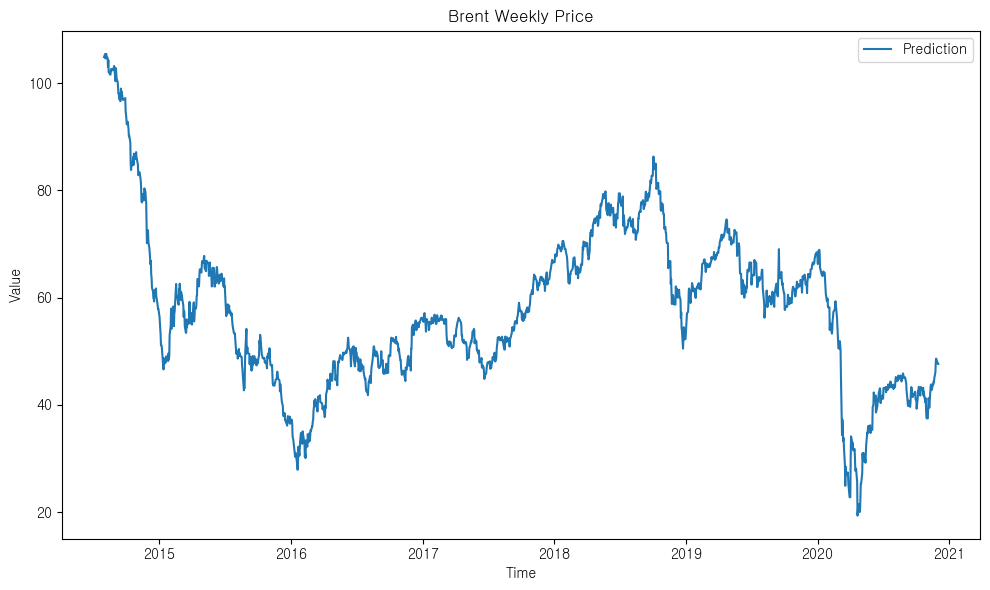

In [143]:
plt.figure(figsize=(10, 6))
plt.plot(BL.loc['2014-08-01':'2020-12-01', 'Adj Close'], label='Prediction')
plt.title('Brent Weekly Price')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

In [168]:
CL_vol = CL['Adj Close'].pct_change().apply(lambda x: np.log(1 + x)).rolling(window=5).var().resample('W').mean().dropna()
HO_vol = HO['Adj Close'].pct_change().apply(lambda x: np.log(1 + x)).rolling(window=5).var().resample('W').mean().dropna()
RB_vol = RB['Adj Close'].pct_change().apply(lambda x: np.log(1 + x)).rolling(window=5).var().resample('W').mean().dropna()
BL_vol = BL['Adj Close'].pct_change().apply(lambda x: np.log(1 + x)).rolling(window=5).var().resample('W').mean().dropna()
# SP_vol = SP['price'].pct_change().apply(lambda x: np.log(1 + x)).rolling(window=5).var().resample('W').mean().dropna()

In [178]:
CL['log_r'] = CL['Adj Close'].pct_change().apply(lambda x: np.log(1 + x))
HO['log_r'] = HO['Adj Close'].pct_change().apply(lambda x: np.log(1 + x))
RB['log_r'] = RB['Adj Close'].pct_change().apply(lambda x: np.log(1 + x))
BL['log_r'] = BL['Adj Close'].pct_change().apply(lambda x: np.log(1 + x))
# SP['log_r'] = SP['price'].pct_change().apply(lambda x: np.log(1 + x))

In [179]:
CL['r'] = CL['Adj Close'].pct_change()
HO['r'] = HO['Adj Close'].pct_change()
RB['r'] = RB['Adj Close'].pct_change()
BL['r'] = BL['Adj Close'].pct_change()
# SP['r'] = SP['price'].pct_change()

In [180]:
CL_vol=((CL['r']-CL['log_r'])).rolling(window=5).mean().resample('W').mean().dropna()
HO_vol=((HO['r']-HO['log_r'])).rolling(window=5).mean().resample('W').mean().dropna()
RB_vol=((RB['r']-RB['log_r'])).rolling(window=5).mean().resample('W').mean().dropna()
BZ_vol=((BL['r']-BL['log_r'])).rolling(window=5).mean().resample('W').mean().dropna()
# SP_vol=((SP['r']-SP['log_r'])*2).rolling(window=5).mean().resample('W').mean().dropna()

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Volatility')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Value')

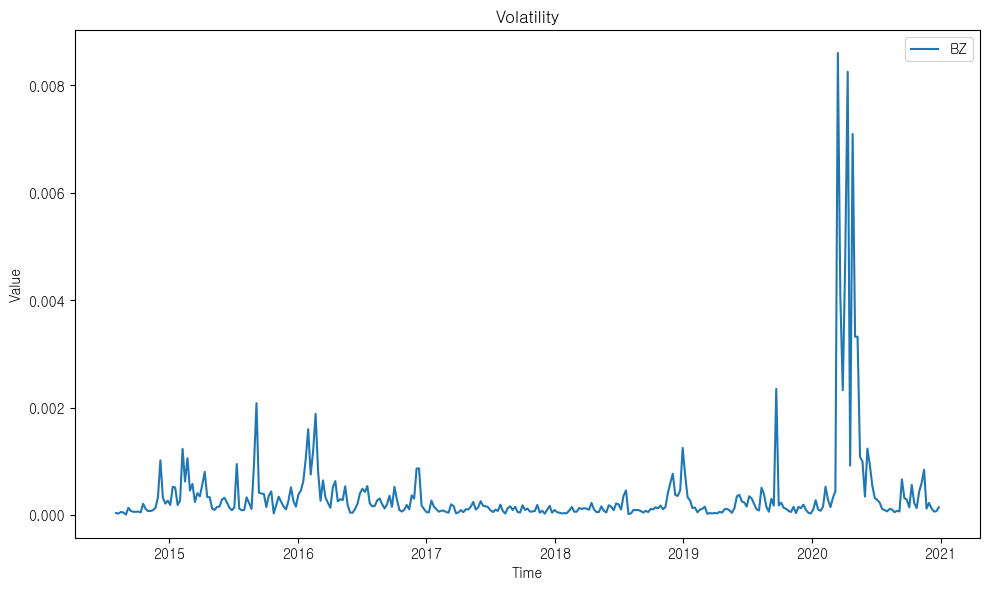

In [181]:
plt.figure(figsize=(10, 6))
plt.plot(BZ_vol.loc['2014-08-01':'2020-12-31'], label='BZ')
plt.title('Volatility')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

In [346]:
CL_vol = CL_vol.dropna()
HO_vol = HO_vol.dropna()
RB_vol = RB_vol.dropna()
BZ_vol = BZ_vol.dropna()
SP_vol = SP_vol.dropna()

In [347]:
CL_vol.index = pd.to_datetime(CL_vol.index)
HO_vol.index = pd.to_datetime(HO_vol.index)
RB_vol.index = pd.to_datetime(RB_vol.index)
BZ_vol.index = pd.to_datetime(BZ_vol.index)
SP_vol.index = pd.to_datetime(SP_vol.index)
vol_list = [CL_vol, HO_vol, RB_vol, BZ_vol, SP_vol]

# Index

In [6]:
DJ = yf.download('^DJI', start='1986-01-01')

[*********************100%%**********************]  1 of 1 completed


# Treasure Yield

In [224]:
import requests

api_key = 'AJPT9SW0WL4NNYHN'

url = 'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=monthly&maturity=10year&apikey=demo'

params = {
    'function': 'TREASURY_YIELD',
    'interval': 'daily',
    'maturity': '30year',
    'apikey': api_key
}

r = requests.get(url, params=params)
yield_30 = r.json()

In [225]:
import requests

api_key = 'AJPT9SW0WL4NNYHN'

url = 'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=monthly&maturity=10year&apikey=demo'

params = {
    'function': 'TREASURY_YIELD',
    'interval': 'daily',
    'maturity': '7year',
    'apikey': api_key
}

r = requests.get(url, params=params)
yield_7 = r.json()

In [226]:
import requests

api_key = 'AJPT9SW0WL4NNYHN'

url = 'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=monthly&maturity=10year&apikey=demo'

params = {
    'function': 'TREASURY_YIELD',
    'interval': 'daily',
    'maturity': '3month',
    'apikey': api_key
}

r = requests.get(url, params=params)
yield_3m = r.json()

In [227]:
yield_30_df = pd.DataFrame(columns=['date', '30_yield'])
for i in range(len(yield_30['data'])):
    yield_30_df.loc[i, 'date'] = yield_30['data'][i]['date']
    yield_30_df.loc[i, '30_yield'] = yield_30['data'][i]['value']
yield_30_df.set_index(yield_30_df['date'], inplace=True)
yield_30_df = yield_30_df.drop(columns=['date'])

In [228]:
yield_7_df = pd.DataFrame(columns=['date', '7_yield'])
for i in range(len(yield_7['data'])):
    yield_7_df.loc[i, 'date'] = yield_7['data'][i]['date']
    yield_7_df.loc[i, '7_yield'] = yield_7['data'][i]['value']
yield_7_df.set_index(yield_7_df['date'], inplace=True)
yield_7_df = yield_7_df.drop(columns=['date'])

In [229]:
yield_3m_df = pd.DataFrame(columns=['date', '3m_yield'])
for i in range(len(yield_3m['data'])):
    yield_3m_df.loc[i, 'date'] = yield_3m['data'][i]['date']
    yield_3m_df.loc[i, '3m_yield'] = yield_3m['data'][i]['value']
yield_3m_df.set_index(yield_3m_df['date'], inplace=True)
yield_3m_df = yield_3m_df.drop(columns=['date'])

In [230]:
yield_list = [yield_30_df, yield_7_df, yield_3m_df]

In [231]:
for per in yield_list:
    per.index = pd.to_datetime(per.index)

In [232]:
for i, vol in enumerate(vol_list):
    for per in yield_list:
        vol = pd.concat([vol, per], axis=1)
        vol = vol.dropna(subset=['return'])
        vol.replace('.', np.nan, inplace=True)
        vol = vol.ffill()
        vol_list[i] = vol

In [243]:
from sklearn.preprocessing import MinMaxScaler

for i, vol in enumerate(vol_list):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(vol.iloc[:, 1:])
    data_scaled = pd.DataFrame(data_scaled, index=vol.index)
    vol = pd.concat([vol.iloc[:, 0], data_scaled], axis=1)
    vol_list[i] = vol

# Text Data Preprocessing

In [198]:
text_data = pd.read_parquet('Database/newsdata.parquet')

In [199]:
NLP_vec = text_data[['date', 'embeddings']].reset_index()
NLP_vec.index = NLP_vec['date']
NLP_vec = NLP_vec['embeddings']

In [200]:
new_columns = {f'{i}': pd.Series(dtype='object') for i in range(384)}
new_df = pd.DataFrame(new_columns)

for i in range(384):
    new_df[f'{i}'] = NLP_vec.apply(lambda x: f'{x[i]}')

In [211]:
# for i, vol in enumerate(vol_list):
#     vol_list[i] = pd.concat([vol, new_df], axis=1)
#     vol_list[i] = vol_list[i].dropna(subset=['return'])
#     nan_index = vol_list[i][vol_list[i]['0'].isna()].index
#     vol_list[i].loc[nan_index] = 0
#     vol_list[i] = vol_list[i].drop(columns=['embeddings'])

In [201]:
test = pd.concat([vol_list[4], new_df], axis=1)
test = test.loc[:'2001-12-30']
mask = (test['return'].isna() == False) & (test['0'].isna() == True)
previous_values = test.shift(1)
masked_previous_values = previous_values[mask]
test.loc[mask, '0':] = masked_previous_values.loc[:, '0':]
test = test.dropna(subset=['return'])
test.loc[test.index[test.isna().any(axis=1)], '0':] = new_df.loc['2000-01-03'].values

In [213]:
vol_list[4] = test

# Save Files

In [214]:
name_list = ['CL_vol', 'HO_vol', 'RB_vol', 'BZ_vol', 'SP_vol']
for i, vol in enumerate(name_list):
    if i != 4:
        vol_list[i].to_csv(f'Database/future_std/{vol}.csv')
    else:
        vol_list[i].to_csv(f'Database/spot_std/{vol}.csv')